In [1]:
import torch
import torch.nn as nn
from torch.functional import F
import matplotlib
import matplotlib.pyplot as plt
from pathlib import Path
import re
from collections import Counter
import random

# Data prep

In [2]:
path = Path('.')
path_comb = path/"treebank"/"treebank"/"combined"
path_comb

PosixPath('treebank/treebank/combined')

In [3]:
files = [o for o in path_comb.iterdir()]

In [4]:
files.pop(0)

PosixPath('treebank/treebank/combined/README')

In [5]:
combineds = [file.open().read() for file in files]

In [6]:
def get_pairs(texts):
    all_pairs = []
    for text in texts:
        pairs = re.findall(r'\((\S+) (\S+)\)', text)
        all_pairs += pairs
    return all_pairs

In [7]:
all_pairs = get_pairs(combineds)
len(all_pairs)

100676

In [8]:
all_pairs[:10]

[('NNP', 'Pierre'),
 ('NNP', 'Vinken'),
 (',', ','),
 ('CD', '61'),
 ('NNS', 'years'),
 ('JJ', 'old'),
 (',', ','),
 ('MD', 'will'),
 ('VB', 'join'),
 ('DT', 'the')]

In [9]:
all_pairs = [[tag,tok] for tag,tok in all_pairs if tag != '-NONE-']
len(all_pairs)

94084

In [10]:
tags,toks = list(zip(*all_pairs))

# Baseline

Frequency of most common tag:

In [11]:
most_common = Counter(tags).most_common()[0]
most_common

('NN', 13166)

In [12]:
freq = most_common[1]
freq

13166

In [13]:
freq / len(tags)

0.13993877811317545

So if we predicted the most common tag, we would only get around 14% accuracy.

## Transforms

In [14]:
class BaseTransform():
    def __init__(self, vocab):
        self.vocab = vocab
        self.count = len(self.vocab)
        self.item2num = {item:num for num,item in enumerate(self.vocab)}
        self.num2item = {num:item for num,item in enumerate(self.vocab)}
    
    def encode(self,o):
        return torch.tensor([self.item2num[item] for item in o])
    
    def decode(self,o):
        return [self.num2item[num] for num in o.tolist()]

In [15]:
class TokTransform(BaseTransform):
    def __init__(self, items):
        vocab = ['xxunk', 'xxpad'] + [item for item,count in Counter(items).most_common()]
        super().__init__(vocab)

In [16]:
class TagTransform(BaseTransform):
    def __init__(self, items):
        vocab = [item for item,count in Counter(items).most_common()]
        super().__init__(vocab)

In [17]:
def get_sentences(pairs):
    sentences = []
    sentence = []
    for label,tok in all_pairs:
        sentence.append([label,tok])
        if label == '.' and tok == '.':
            sentences.append(sentence)
            sentence = []
    return sentences

In [18]:
tok_tfm = TokTransform(toks)
tag_tfm = TagTransform(tags)

In [19]:
sentences = get_sentences(all_pairs)

### These are the raw items that will be indexed in the data loader:

In [20]:
x_toks = [[tok for tag,tok in sentence] for sentence in sentences]
y_tags = [[tag for tag,tok in sentence] for sentence in sentences]
assert(len(x_toks) == len(y_tags))

### These are the tensors:

In [21]:
x = [tok_tfm.encode(sentence) for sentence in x_toks]
y = [tag_tfm.encode(sentence) for sentence in y_tags]
assert(len(x) == len(y))

# Train / Val split

In [22]:
len(x)

3828

In [23]:
cut = int(len(x) * .8)
cut

3062

In [24]:
range(cut), range(cut,len(x))

(range(0, 3062), range(3062, 3828))

In [25]:
x_train, x_val = x[:cut], x[cut:]
y_train, y_val = y[:cut], y[cut:]

In [26]:
assert len(x_train) == len(y_train)
assert len(x_val) == len(y_val)

# Dataloading

In [27]:
class DataLoader():
    def __init__(self, x_set, y_set, bs):
        self.x_set, self.y_set, self.bs = x_set, y_set, bs
        self.n_items = len(self.x_set)
    
    def get_batches(self):
        self.x_set, self.y_set = self._shuffle_same(self.x_set, self.y_set)
        for start in range(0,self.n_items,self.bs):
            end = start + self.bs
            if end > self.n_items:
                end = self.n_items
            xb, yb = self.x_set[start:end], self.y_set[start:end]
            xb, yb = self._pad_stack(xb), self._pad_stack(yb)
            assert xb.shape == yb.shape
            yield xb, yb
    
    def _shuffle_same(self, x_set, y_set):
        "Shuffle both x_set and y_set, but keep them lined up with each other"
        zipped = list(zip(x_set, y_set))
        random.shuffle(zipped)
        return list(zip(*zipped))
    
    def _pad_to(self, t, max_len):
        "Pad vector tensor t to be of length max_len"
        assert len(t.shape) == 1
        return F.pad(t, (0,max_len-len(t)), value=1)
    
    def _pad_stack(self, batch):
        max_len = max(map(len, batch))
        return torch.stack([self._pad_to(t,max_len) for t in batch])

In [28]:
class DataLoaders():
    def __init__(self, train, val):
        self.train, self.val = train, val

Create dls:

In [29]:
bs = 64
dl_train = DataLoader(x_train, y_train, bs)
dl_val = DataLoader(x_val, y_val, bs)
dls = DataLoaders(dl_train, dl_val)

# Model

In [30]:
class TagModel(nn.Module):
    def __init__(self, voc_sz, emb_sz, hid_sz, out_sz):
        super().__init__()
        self.emb = nn.Embedding(voc_sz, emb_sz)
        self.lstm = nn.LSTM(emb_sz, hid_sz, num_layers=3, batch_first=True)
        self.lin = nn.Linear(hid_sz, out_sz)
    
    def forward(self,x):
        out = self.emb(x)
        out,h = self.lstm(out)
        out = self.lin(out)
        return out

In [31]:
voc_sz = tok_tfm.count
emb_sz = 100
hid_sz = 500
out_sz = tag_tfm.count

voc_sz, out_sz

(11970, 45)

In [32]:
model = TagModel(voc_sz, emb_sz, hid_sz, out_sz)

# Loss

In [33]:
def tag_loss(preds, targ):
    preds = preds.view(-1, tag_tfm.count)
    targ = targ.view(-1)
    return F.cross_entropy(preds, targ)

# Optimizer

In [34]:
opt = torch.optim.Adam(model.parameters())

# Metrics (accuracy)

In [35]:
def accuracy(preds, targ):
    nums = preds.argmax(dim=-1)
    return (nums == targ).float().mean()

# Learner

In [36]:
class Learner():
    def __init__(self, dls, model, loss_func, opt, metric):
        self.dls, self.model, self.loss_func, self.opt, self.metric = dls, model, loss_func, opt, metric
        self.train_loss_log = []
        self.val_loss_log = []
        self.metric_log = []
    
    def fit(self, n_epochs):
        for epoch in range(n_epochs):
            print(f"Epoch {epoch}: ", end='')
            train_loss = self.train_epoch()
            self.train_loss_log.append(train_loss)
            val_loss, metric = self.validate()
            self.val_loss_log.append(val_loss)
            self.metric_log.append(metric)
    
    def train_epoch(self):
        train_losses = []
        self.model.train()
        for xb,yb in self.dls.train.get_batches():
            preds = self.model(xb)
            loss = self.loss_func(preds, yb)
            train_losses.append(loss.item())
            loss.backward()
            self.opt.step()
            self.opt.zero_grad()
#             print('.', end='')
#         print()
        mean_loss = torch.tensor(train_losses).mean().item()
#         print(f"Train loss: {mean_loss}")
        return mean_loss
    
    def validate(self):
        valid_losses = []
        metrics = []
        self.model.eval()
        with torch.no_grad():
            for xb,yb in self.dls.val.get_batches():
                preds = self.model(xb)
                loss = self.loss_func(preds, yb)
#                 print('.', end='')
                valid_losses.append(loss)
                metrics.append(accuracy(preds, yb))
#         print()
        mean_loss = torch.tensor(valid_losses).mean().item()
#         print(f"Valid loss: {mean_loss}")
        mean_metric = torch.tensor(metrics).mean().item()
        print(f"Metric: {mean_metric}")
        return mean_loss, mean_metric

In [37]:
learn = Learner(dls, model, tag_loss, opt, accuracy)

In [38]:
learn.fit(10)

Epoch 0: Metric: 0.6227027773857117
Epoch 1: Metric: 0.7453997135162354
Epoch 2: Metric: 0.8046727180480957
Epoch 3: Metric: 0.8484501242637634
Epoch 4: Metric: 0.8707658648490906
Epoch 5: Metric: 0.897190272808075
Epoch 6: Metric: 0.9076550602912903
Epoch 7: Metric: 0.9145600199699402
Epoch 8: Metric: 0.9204342365264893
Epoch 9: Metric: 0.9261152744293213


# Baseline on validation set

In [47]:
val_tags = torch.cat(y_val)
val_tags_dec = tag_tfm.decode(val_tags)
val_tags_dec[:10]

['DT', 'NNS', 'VBD', 'DT', 'NNP', 'POS', 'NN', 'VBZ', 'TO', 'VB']

In [49]:
most_common = Counter(val_tags_dec).most_common()
most_common[:10]

[('NN', 2926),
 ('IN', 1964),
 ('NNP', 1805),
 ('DT', 1625),
 ('NNS', 1133),
 ('JJ', 1094),
 ('CD', 1041),
 (',', 934),
 ('.', 768),
 ('VBD', 747)]

In [62]:
def bar_chart(items):
    tags,freqs = zip(*items)
    xi = range(len(tags))
    
    fig, ax = plt.subplots()
    ax.bar(xi, freqs)
    plt.xticks(xi, tags)
    plt.show()

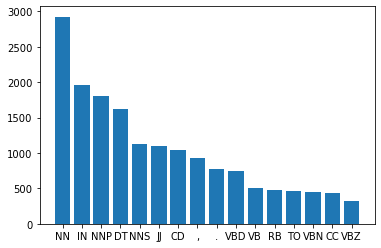

In [68]:
bar_chart(most_common[:16])

In [70]:
most_common[0]

('NN', 2926)

In [71]:
most_common_freq = most_common[0][1]
most_common_freq

2926

In [72]:
total_freqs = len(val_tags_dec)
total_freqs

18818

In [73]:
most_common_freq / total_freqs

0.15548942501859922

So on the validation set, we would get less than 16% accuracy by predicting the most common tag.

## Plot curves

In [74]:
def plot(log):
    epoch = range(len(log))
    fig, ax = plt.subplots()
    ax.plot(epoch, log)
    ax.grid()
    plt.show()

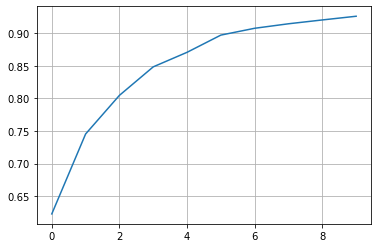

In [75]:
plot(learn.metric_log)

# Inference

In [77]:
pred = learn.model(x_val[0][None,:])
pred.shape

torch.Size([1, 29, 45])

In [78]:
nums = pred.argmax(dim=-1)
nums.shape

torch.Size([1, 29])

In [79]:
nums = nums.squeeze()
nums

tensor([ 3,  4,  9,  3,  2, 20,  0, 15, 13, 11,  0,  0,  4, 10,  0,  0,  1,  3,
         4,  6, 14,  8,  1, 21,  3,  0, 19, 11,  7])

In [81]:
import pandas as pd

In [83]:
list(zip(tok_tfm.decode(x_val[0]), tag_tfm.decode(y_val[0]), tag_tfm.decode(nums)))

[('Some', 'DT', 'DT'),
 ('dealers', 'NNS', 'NNS'),
 ('said', 'VBD', 'VBD'),
 ('the', 'DT', 'DT'),
 ('Treasury', 'NNP', 'NNP'),
 ("'s", 'POS', 'POS'),
 ('intent', 'NN', 'NN'),
 ('is', 'VBZ', 'VBZ'),
 ('to', 'TO', 'TO'),
 ('help', 'VB', 'VB'),
 ('government', 'NN', 'NN'),
 ('bond', 'NN', 'NN'),
 ('dealers', 'NNS', 'NNS'),
 ('gauge', 'VB', 'RB'),
 ('investor', 'NN', 'NN'),
 ('demand', 'NN', 'NN'),
 ('for', 'IN', 'IN'),
 ('the', 'DT', 'DT'),
 ('securities', 'NNS', 'NNS'),
 (',', ',', ','),
 ('given', 'VBN', 'VBN'),
 ('uncertainties', 'NNS', 'CD'),
 ('about', 'IN', 'IN'),
 ('when', 'WRB', 'PRP$'),
 ('the', 'DT', 'DT'),
 ('auction', 'NN', 'NN'),
 ('will', 'MD', 'MD'),
 ('occur', 'VB', 'VB'),
 ('.', '.', '.')]

In [ ]:
tok_tfm.decode

In [97]:
idx = 2
tokens = tok_tfm.decode(x_val[idx])
labels = tag_tfm.decode(y_val[idx])
preds = tag_tfm.decode(learn.model(x_val[idx][None,:]).argmax(dim=-1).squeeze())
df = pd.DataFrame({'Token': tokens, 'Label': labels, 'Pred': preds})
df['Correct'] = df['Label'] == df['Pred']
df

,Token,Label,Pred,Correct
0,Until,IN,NNP,False
1,such,JJ,JJ,True
2,action,NN,NN,True
3,takes,VBZ,VBZ,True
4,places,NNS,NNS,True
5,",",",",",",True
6,the,DT,DT,True
7,Treasury,NNP,NNP,True
8,has,VBZ,VBZ,True
9,no,DT,DT,True


Next steps:

- analyze model's most common errors, and try to improve model based on those

- create Recorder class to log losses/metrics over all epochs

- record avg accuracy per tag overall

save best model
- after every epoch, if current params are better than saved params, save current params and delete old params
- only have 1 model saved at a time, to save space
- never lose best model's params

- tokenize from raw sentences

- add docstrings for my functions

- add tests for my functions